# Presentation

In this notebook we explore 1D optimal transport by computing the barycenter between spectra. 

We'll first explore 1D OT on diracs followed by 1D OT on gaussians. In the end we explore this method on real signals.

We'll compute barycenters using 3 functions:

* Quantile method   
* ~~Entropic barycenter~~ 
* ~~Regularized sinkhorn~~

In [6]:
import librosa
import IPython
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import ot

## OT between diracs

In this part we compute 1D Optimal transport between diracs


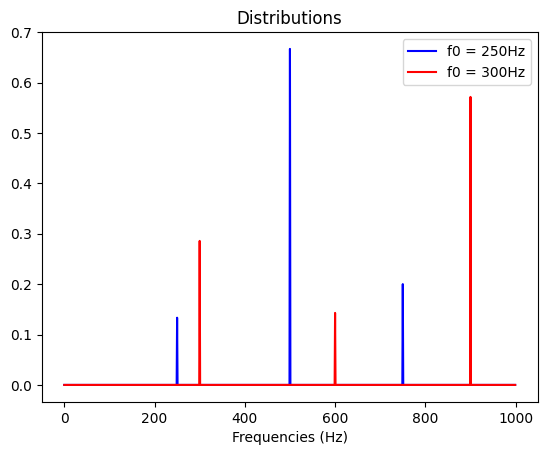

In [7]:
# Define dirac distributions

n = 1000

def dirac_distribution(frequencies, values, n=1000):
    if not len(frequencies) == len(values):
        raise ValueError("Arrays should be same size")
    
    a = np.zeros(n)
    for i in range(len(frequencies)):
        f = int(frequencies[i])
        v = values[i]
        a[f] = v
    return a / np.sum(a)

f1 = n * 0.25
f2 = n * 0.3

a1 = dirac_distribution([f1, f1*2, f1*3], [0.2, 1, 0.3], n=n)
a2 = dirac_distribution([f2, f2*2, f2*3], [1, 0.5, 2], n=n)

frequencies = np.arange(n)

plt.plot(frequencies, a1, color="blue", label=f"f0 = {f1:.0f}Hz")
plt.plot(frequencies, a2, color="red", label=f"f0 = {f2:.0f}Hz")
plt.title('Distributions')
plt.xlabel("Frequencies (Hz)")
plt.legend()

plt.show()



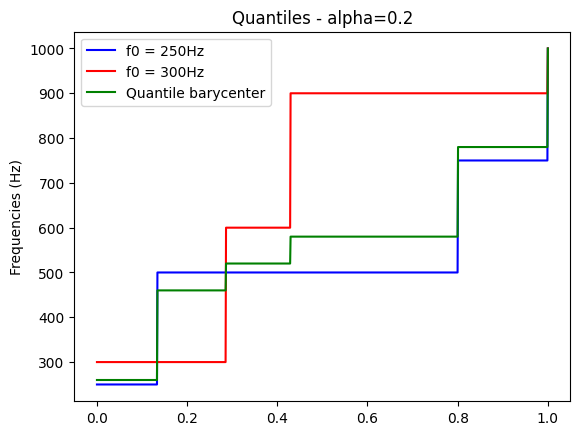

In [8]:
# Define quantile and quantile barycenter functions
# Plot quantiles and quantile barycenter

alpha = 0.2

def quantile(a):
    n = len(a)
    X = np.cumsum(a)
    U = np.linspace(0, 1, n)
    return np.searchsorted(X, U, side='right')

def quantile_bary(a1, a2, alpha=0.5):
    q1 = quantile(a1)
    q2 = quantile(a2)
    return (1 - alpha) * q1 + alpha * q2

U = np.linspace(0, 1, n)

plt.plot(U,quantile(a1), color="blue", label=f"f0 = {f1:.0f}Hz")
plt.plot(U,quantile(a2), color="red", label=f"f0 = {f2:.0f}Hz")
plt.plot(U,quantile_bary(a1, a2, alpha=alpha), color="green", label="Quantile barycenter")
plt.ylabel("Frequencies (Hz)")
plt.title(f"Quantiles - alpha={alpha}")
plt.legend()
plt.show()


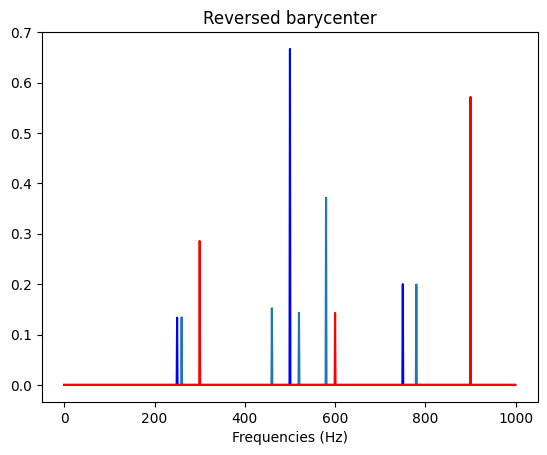

In [9]:
# reverse quantile barycenter using dirac distribution function

z = quantile_bary(a1, a2, alpha=alpha)

def reverse_bary(z):
    n = len(z)
    frequencies, values = np.unique(z, return_counts=True)
    return dirac_distribution(frequencies[:-1], values[:-1], n=n)

plt.plot(frequencies, reverse_bary(z))
plt.plot(frequencies, a1, color="blue")
plt.plot(frequencies, a2, color="red")
plt.xlabel("Frequencies (Hz)")
plt.title("Reversed barycenter")
plt.show()

# Between gaussians

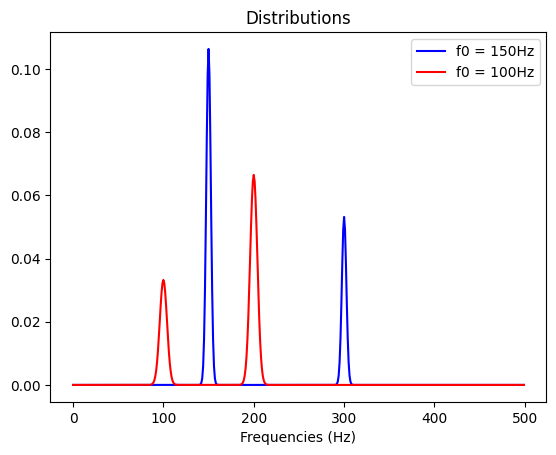

In [10]:
# We compute two 1000-bins gaussian distributions with different mean and std

n = 500
frequencies = np.arange(n, dtype=np.float64)

f1 = n * 0.3
f2 = n * 0.2
s1 = n * 0.005
s2 = n * 0.008

# Gaussian distributions
a1 = 1.0 * ot.datasets.make_1D_gauss(n, m=f1, s=s1) + 0.5 * ot.datasets.make_1D_gauss(n, m=f1*2, s=s1)
a1 = a1 / np.sum(a1)
a2 = 0.5 * ot.datasets.make_1D_gauss(n, m=f2, s=s2) + 1.0 * ot.datasets.make_1D_gauss(n, m=f2*2, s=s2)
a2 = a2 / np.sum(a2)

plt.plot(frequencies, a1, color="blue", label=f"f0 = {f1:.0f}Hz")
plt.plot(frequencies, a2, color="red", label=f"f0 = {f2:.0f}Hz")
plt.title('Distributions')
plt.legend()
plt.xlabel("Frequencies (Hz)")
plt.show()

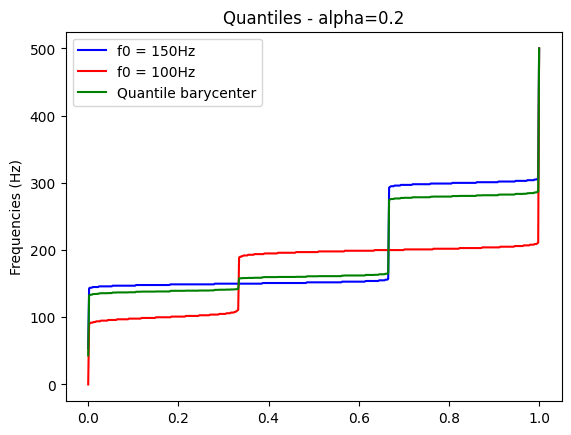

In [11]:
# Plot quantiles and barycenter quantile

alpha = 0.2

U = np.linspace(0, 1, n)

plt.plot(U,quantile(a1), color="blue", label=f"f0 = {f1:.0f}Hz")
plt.plot(U,quantile(a2), color="red", label=f"f0 = {f2:.0f}Hz")
plt.plot(U,quantile_bary(a1, a2, alpha=alpha), color="green", label="Quantile barycenter")
plt.ylabel("Frequencies (Hz)")
plt.title(f"Quantiles - alpha={alpha}")
plt.legend()
plt.show()


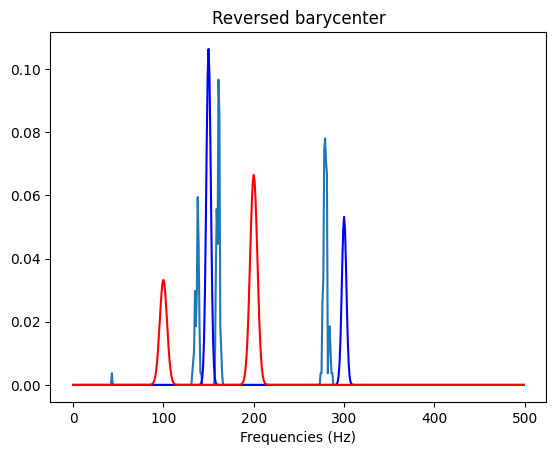

In [12]:
# reverse quantile barycenter using dirac distribution function

z = quantile_bary(a1, a2, alpha=alpha)

plt.plot(frequencies, reverse_bary(z))
plt.plot(frequencies, a1, color="blue")
plt.plot(frequencies, a2, color="red")
plt.xlabel("Frequencies (Hz)")
plt.title("Reversed barycenter")
plt.show()

# On real signals

In [45]:
from math import log2

duration = 0.3 # in seconds

smooth_len = 1000 # éviter effets de bord
smoothing = np.linspace(0, 1, smooth_len)


A_signal, sr = librosa.load('A.wav', sr=44100, duration=duration)
A_signal[:smooth_len] *= smoothing
A_signal[-smooth_len:] *= np.flip(smoothing)
C_signal, _ = librosa.load('C.wav', sr=44100, duration=duration)
C_signal[:smooth_len] *= smoothing
C_signal[-smooth_len:] *= np.flip(smoothing)

fft_ms = 23 # window size in ms
n_fft = 2**round(log2(fft_ms*1e-3*sr)) # dans le cas d'un signal continue on priviliégie une résolution spectrale
A_fft = librosa.stft(A_signal, n_fft=n_fft)
C_fft = librosa.stft(C_signal, n_fft=n_fft)

n_fft

1024

In [46]:
# Optimal transport

signals = []
alpha_arr = np.linspace(0, 1, 10) # compute OT for multiple values of alpha

for alpha in alpha_arr:
    interpolated_signal = []
    for index in range(A_fft.shape[1]):
        A_frame = A_fft[:,index]
        A_frame = np.abs(A_frame)
        A_frame = A_frame / np.sum(A_frame)
        C_frame = C_fft[:,index]
        C_frame = np.abs(C_frame)
        C_frame = C_frame / np.sum(C_frame)

        z_frame = quantile_bary(A_frame, C_frame, alpha=alpha)
        interpolated_frame = reverse_bary(z_frame)
        interpolated_signal.append(interpolated_frame)
    
    signals.append(np.array(interpolated_signal))

signals = np.array(signals)


C:\Users\David\AppData\Local\Temp\ipykernel_1972\3731231670.py:5: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(A_fft, ref=np.max), y_axis='linear', x_axis='time', ax=ax[0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
C:\Users\David\AppData\Local\Temp\ipykernel_1972\3731231670.py:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(C_fft, ref=np.max), y_axis='linear', x_axis='time', ax=ax[1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)


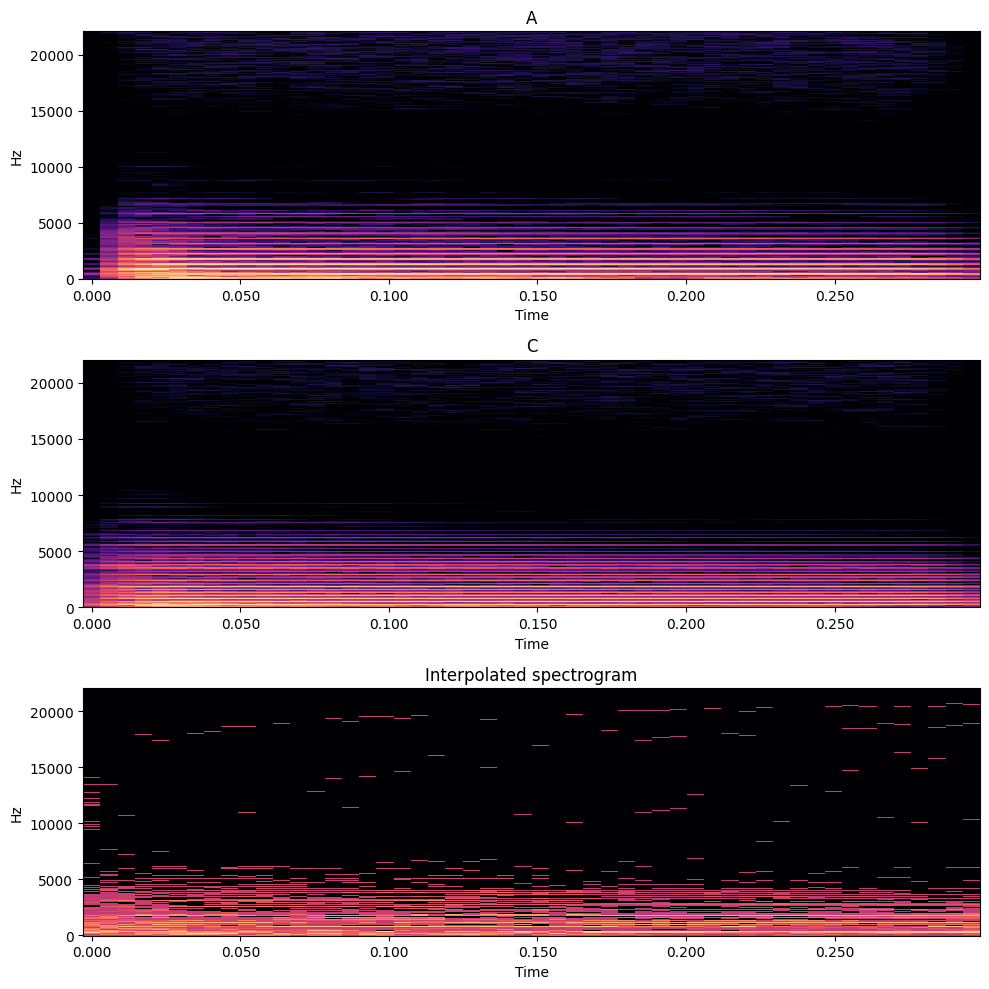

In [47]:
signals = np.array([signal.T for signal in signals])
plot_signal_index = 5

fig, ax = plt.subplots(3, 1, figsize=(10,10))
librosa.display.specshow(librosa.amplitude_to_db(A_fft, ref=np.max), y_axis='linear', x_axis='time', ax=ax[0], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
librosa.display.specshow(librosa.amplitude_to_db(C_fft, ref=np.max), y_axis='linear', x_axis='time', ax=ax[1], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
librosa.display.specshow(librosa.amplitude_to_db(signals[plot_signal_index], ref=np.max), y_axis='linear', x_axis='time', ax=ax[2], sr=sr, n_fft=n_fft, hop_length=n_fft//4)
ax[0].set_title("A")
ax[1].set_title("C")
ax[2].set_title("Interpolated spectrogram")
plt.tight_layout()
plt.show()

In [48]:
audio_widgets = []

title = widgets.Label(f'A4')
audio_player = IPython.display.Audio(data=A_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

title = widgets.Label(f'C5')
audio_player = IPython.display.Audio(data=C_signal, rate=sr)
out = widgets.Output()
with out:
    display(audio_player)
combined_widget = widgets.VBox([title, out])
audio_widgets.append(combined_widget)

# display new sounds
for i, audio in enumerate(signals):
    title = widgets.Label(f'Alpha: {alpha_arr[i]:.2f}')
    inversed = librosa.griffinlim(signals[i], n_iter=100)
    audio_player = IPython.display.Audio(data=inversed, rate=sr)
    out = widgets.Output()
    with out:
        display(audio_player)
    combined_widget = widgets.VBox([title, out])
    audio_widgets.append(combined_widget)

grid = widgets.VBox(audio_widgets)
grid